In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

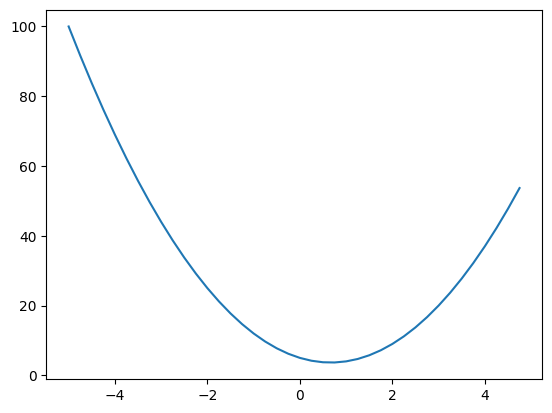

In [2]:
# Question 1

def f(x):
  return 3*x**2 - 4*x + 5

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [3]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [4]:
# Question 2
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [5]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [6]:
class Value: # wraps and keeps track of single value
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0 
        self._backward = lambda: None
        self._prev = set(_children) # set only stored unique items and removes duplicates
        self._op = _op
        self.label = label

    # NOTE: out.grad is used in every gradient accumulation

    def __repr__(self): # this function is represent the output
        return f"Value(data={self.data})"
    
    def __add__(self, other): # defines what addition operator does
        other = other if isinstance(other, Value) else Value(other) # to carry out addition with integer. Eg. a + 1 where a is value object

        out = Value(self.data + other.data, (self, other), '+') # 1. store the older values (children) that are used to computer new value

        def _backward():
            # += accululation of gradients. otherwise the gradient of one parent node overwrites the other
            self.grad += 1.0 * out.grad # during back propagation the gradient of the output is back propagated. Eg. dL / dc = ( dL / dd ) * ( dd / dc ) = ( dL / dd ) * d(c+e)/dc = ( dL / dd ) x 1 = out.grad * 1.0
            other.grad += 1.0 * out.grad # See graph below for above example
        out._backward = _backward # lambda function storing. when backward is needed to be called then ._backward() is used
        return out 
    
    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __neg__(self): # -self
        return self * -1

    def __mul__(self, other): # defines what multiplication operator does
        other = other if isinstance(other, Value) else Value(other) # to carry out multiplication with integer. Eg. a * 2 where a is value object

        out = Value(self.data * other.data, (self, other), '*') # 2. (self, other) is passed to _children tuple and stored

        def _backward():
            # += accululation of gradients. otherwise the gradient of one parent node overwrites the other
            self.grad += other.data * out.grad # dL / db = ( dL / dd ) * ( dd / de ) * ( de / db ) = ( dL / dd ) * ( dd / de ) * a = out.grad * other.data
            other.grad += self.data * out.grad
        out._backward = _backward # lambda function storing. when backward is needed to be called then ._backward() is used
        return out
    
    def __rmul__(self, other): # other * self
        return self * other # Eg. if 2 * a is not possible then do a * 2
    
    def __truediv__(self, other): # self / other
        return self * other**-1 # self / other  = self * (other ^ -1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad # dx^n / dx = n * x^(n-1)
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)

        def _backward():
            # += accululation of gradients. otherwise the gradient of one parent node overwrites the other
            self.grad += (1 - t**2) * out.grad # from formula

        out = Value(t, (self, ), 'tanh') # activation function gets 1 input for an output. So only one child i.e. (self, )
        out._backward = _backward # lambda function storing. when backward is needed to be called then ._backward() is used
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # data * grad. out is used from above. de^x / dx = e^x
        out._backward = _backward

        return out
    
    def backward(self):
        # Topological sorting for gradient
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo): # back propagation
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e' # ; can be used in python to write multiple lines in one line
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

In [7]:
L._prev # d was found by addition of (a*b) and c

{Value(data=-2.0), Value(data=4.0)}

In [8]:
L._op # d was found by addition of (a*b) and c

'*'

In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


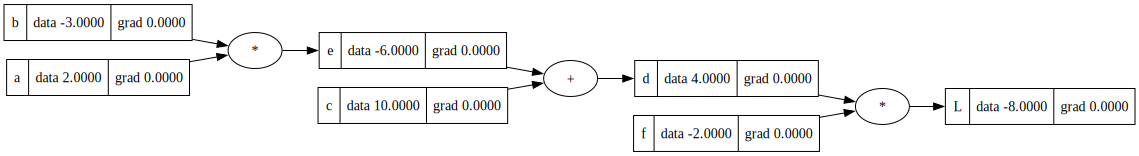

In [10]:
draw_dot(L)

In [11]:
# dL / dd = f
# dL / df = d
# dL / dc = ( dL / dd ) * ( dd / dc ) = f * d(c+e)/dc = f x 1 = f
# dL / db = ( dL / dd ) * ( dd / de ) * ( de / db ) = f * d( e + c ) / de * d( ab )/db = f * 1 * a 
# and so on...


In [12]:
# Manual training example

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-8.0


In [13]:
# Basic NN

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [14]:
# o.grad = 1.0 # dL / dL = 1
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

In [15]:
# Topological sorting of nodes for DAG (Directed Acyclic Graph) 

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [16]:
o.backward()

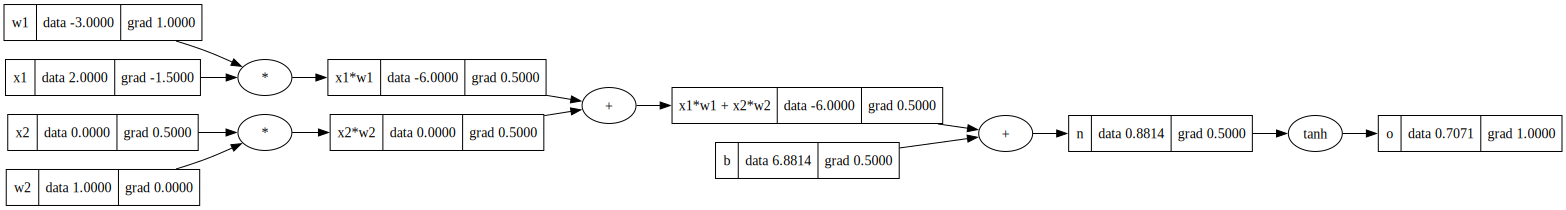

In [17]:
draw_dot(o)

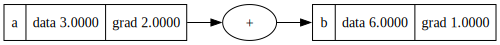

In [18]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

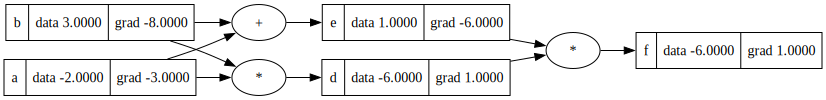

In [19]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

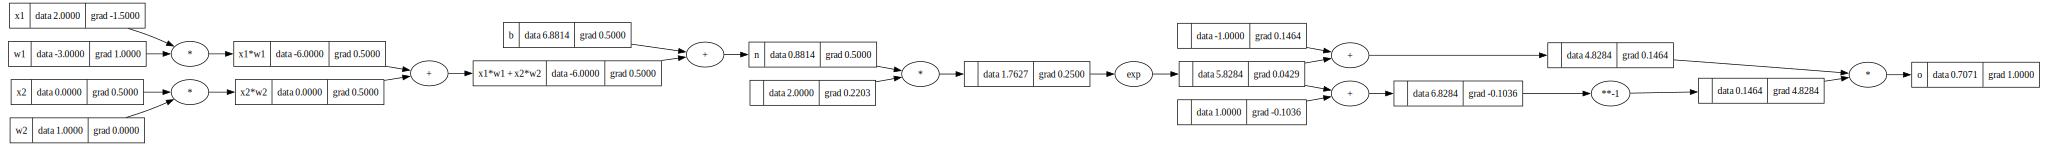

In [20]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---- Defining tanh and using more defined operations
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [21]:
# Doing the exact same thing in pytorch

import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # item returns only the value
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [22]:
# Creating a NN Class

import random

class Neuron: 
    def __init__(self, nin):
        self.w = [(Value(random.uniform(-1, 1))) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x): # returns a value
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # two iterators iterate over the values to create a single iterator for a tuple in zip
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

x = [2.0, 3.0]
n = Neuron(2) # 2 = number of weights
n(x)

Value(data=-0.625034626096398)

In [23]:
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

x = [2.0, 3.0]
n = Layer(2, 3) # Two layers: first layer of two neurons and second layer of 3 neurons
n(x)

[Value(data=-0.24812960295827535),
 Value(data=-0.03236788705305964),
 Value(data=0.6418849686452286)]

In [24]:
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
  
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # consists of 4 layers. First input layer of 3 neurons for 3 inputs. The output is single value from single neuron
n(x), len(n.parameters())

(Value(data=0.6716078918665898), 41)

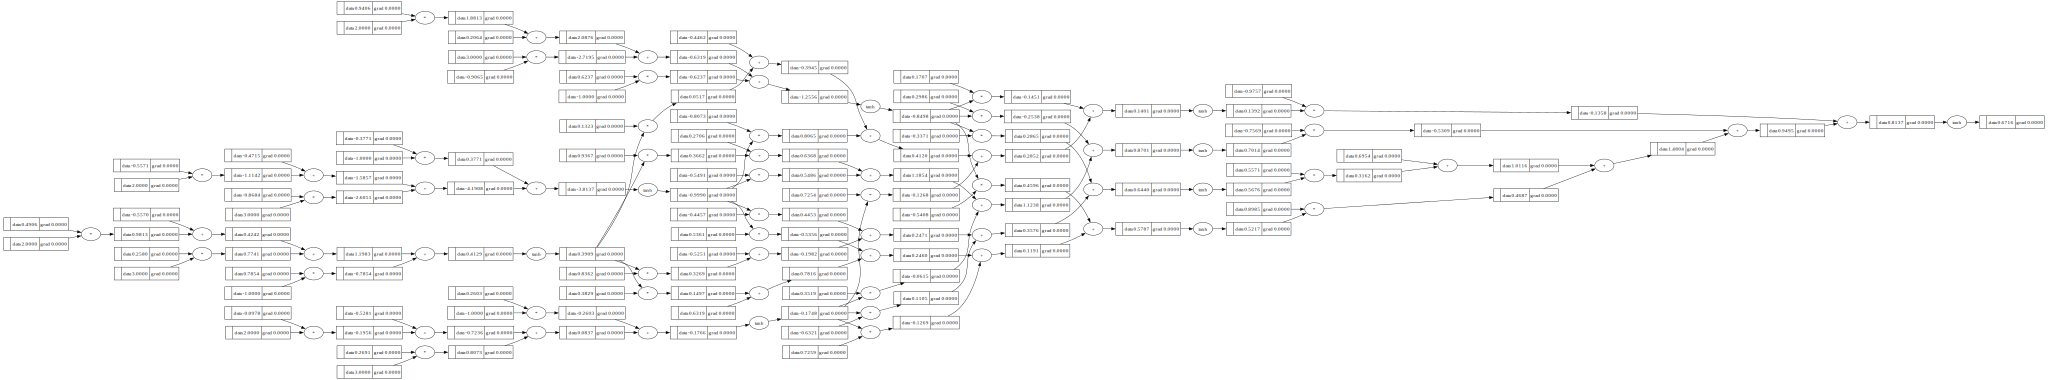

In [25]:
draw_dot(n(x))

In [26]:
# A simple dataset

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs] # MLP
ypred # random weights output

[Value(data=0.6716078918665898),
 Value(data=-0.18364681723849277),
 Value(data=-0.11089644998783207),
 Value(data=0.5858344796609195)]

In [27]:
for k in range(20): # 20 = number of epochs
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad # 0.1 = learning rate
  
  print(k, loss.data)

0 1.7363120965711292
1 1.6565428999682899
2 3.7267429083270724
3 0.006020552653566269
4 0.005703063428711966
5 0.0054194756459399465
6 0.005164533070934717
7 0.004934023840448281
8 0.004724531606433758
9 0.00453325494138331
10 0.004357874036777336
11 0.004196450798689632
12 0.004047352935803471
13 0.003909195553069672
14 0.0037807956994826497
15 0.003661136626106689
16 0.0035493394092312477
17 0.0034446402209263776
18 0.0033463719735449225
19 0.003253949383500364


In [28]:
ypred

[Value(data=0.991949842855361),
 Value(data=-0.9709846761825945),
 Value(data=-0.9524341445885572),
 Value(data=0.9907943095752786)]